
# Equations of Motion
This formualation of the equations of motion follow the generally accepted convention for aircraft and spacecraft:
- describe the equations of motion in body coordinates
- convert the motion in body coordinates to inertial coordinates

Although this seems quite counter-intuitive, the result is much cleaner and the equations are ready for systems dynamic and control analysis.



In [ ]:
import sympy as sp
import sympy.physics.mechanics as me 
import numpy as np
import pandas as pd

from sympy.utilities.iterables import flatten
from scipy.integrate import *
import matplotlib.pyplot as plt


sp.init_printing()

# Start with the rocket motor in rocket body coords
## Transform the motor thrust into Forces and Moments around the rocket CG

<img src="RocketBodyFrames.jpeg" alt="Drawing" style="width: 400px;"/>



Assume to reference frames $N(B)$ and $N(B_1)$ corresponding to the reference frame through the rocket center of mass $(CM)$  and the rocket motor respectively. Note that $N(B_1)$ is merely displaced from $N(B)$ and there is no realative rotation between the two systems.  

$\vec{b}$ is the vector in the $N(B)$ frame to the origin of the $N(B_1)$ frame

The thrust vector ${T}$ is defined in the $N(B_1)$ frame. From a control perspective ${T}$ will be defined as a magnitude and two angles (rotations around $\vec{x}$ and $\vec{y}$ measured from the $z$ axis) relative to the $N(B_1)$ frame. Since there are two motors ($M1$ and $M2$) the magnitude of ${T}$ is the sum of ${T}_{M1}$ and ${T}_{M2}$

$${T}^{control}= u =\begin{bmatrix}
           T_{M1} \\
           T_{M2} \\
           \phi_{Tx} \\
           \phi_{T_y} 
         \end{bmatrix}$$

This can be transformed into $N(B_1)$ frame as follows:
$$T=\begin{bmatrix}
        (T_{M1}+T_{M2})  \cos{\phi_{Tx}} \sin{\phi_{Ty}}\\
           -(T_{M1}+T_{M2}) \sin{\phi_{Tx}} \cos{\phi_{Ty}} \\
           (T_{M1}+T_{M2}) \cos{\phi_{Tx}} \cos{\phi_{Ty}} 
         \end{bmatrix}$$


In [ ]:
# define the symbols
Tm1, Tm2, Tm, thrust_angle_x, thrust_angle_y = sp.symbols(['T_M1','T_M2','T_M','phi_Tx', 'phi_Ty'])

In [ ]:
T_control = sp.Matrix([Tm1, Tm2, thrust_angle_x, thrust_angle_y])
T_control

⎡T_M1⎤
⎢    ⎥
⎢T_M2⎥
⎢    ⎥
⎢φ_Tx⎥
⎢    ⎥
⎣φ_Ty⎦

In [ ]:
T_control.subs({Tm1:1})

⎡ 1  ⎤
⎢    ⎥
⎢T_M2⎥
⎢    ⎥
⎢φ_Tx⎥
⎢    ⎥
⎣φ_Ty⎦

## Yaw moment
The yaw moment aries (around the $z$ axis) from the scenario where the thrust produced by the two counter rotating motors is not equal.  

Assume $M_1$ spins in the positive $z$ direction (anti-clockwise) in the figure below and $M_2$ spins in the negative $z$ direction (clockwise). If $M_1$ produces more thrust than $M_2$ then the reaction torque exerted by $M_1$ will be greater than the reaction torque produced by $M_2$. Since the reaction torque is in the opposite direction of the propeller rotation, this will result in a negative (clockwise) torque on the rocket about the $z$ axis.

<img src="PropRotation.jpeg" alt="Drawing" style="width: 400px;"/>



The total thrust is $T_{M1} + T_{M2}$

Source of the following analysis: https://m-selig.ae.illinois.edu/pubs/DetersAnandaSelig-2014-AIAA-2014-2151.pdf

$T$ : Propeller thrust  
$C_T$ : Propeller thrust coefficient  
$C_P$ : Propeller power coefficient  
$\rho$ : density of air   
$D$ : Propeller diameter  
$n$ : Propeller speed in $rev/s$

$$\begin{align} 
T_{M1} = C_T \rho D^4n_{M1}^2 \tag{1}
\end{align}$$

$$T_{M2} = C_T \rho D^4n_{M2}^2 \tag{2}$$

when there is is a difference in thrust between the motors a torque arises.

The paper above characterizes propellers in terms of their thrust coefficient ($C_T$) and their power coefficients ($C_P$)

The power input to a prop is the product of the torque and the rotational speed:  
$$ P = 2 \pi n \tau \tag{3}$$

The power coefficient is defined as:

$$C_P = \frac{P}{\rho n^3D^5} \tag{4}$$

Substituting 4 into 3 and solving for $\tau$: 


$$ \tau = \frac{C_P \rho  D^5 }{2 \pi } n^2 \tag{5}$$

Assume that the throttle command to the motor is proportional to the rotational velocity $n$ and the rotational speed of the motors are $n_{M1}$ and $n_{M2}$, then the net torque is:

$$ \tau_{M1}-\tau_{M2} = -\frac{C_P \rho D^5}{2 \pi} (n_{M1}^2- n_{M2}^2) \tag{6}$$

Substituting $(1)$ and $(1)$ into  $(6)$:

$$ \tau_{M1}-\tau_{M2} = -\frac{C_P \rho D^5}{2 \pi} ((\frac{T_{M1} }{C_T \rho D^4})- (\frac{T_{M2} }{C_T \rho D^4})) $$

$$ \tau_{M1}-\tau_{M2} = -\frac{D C_P }{2 \pi C_T}(T_{M1}- T_{M2}) \tag{7}$$

From the propeller data in the source above it can be seen that the ratio $\frac{C_P}{C_T}$ is quite constant for most small drone propellers over their operating range of Reynolds numbers. 

$$\frac{C_P}{C_T} = 0.5$$

$$ \Delta\tau_{M1-M2} = -\frac{D}{4 \pi}(T_{M1}- T_{M2}) \tag{8}$$

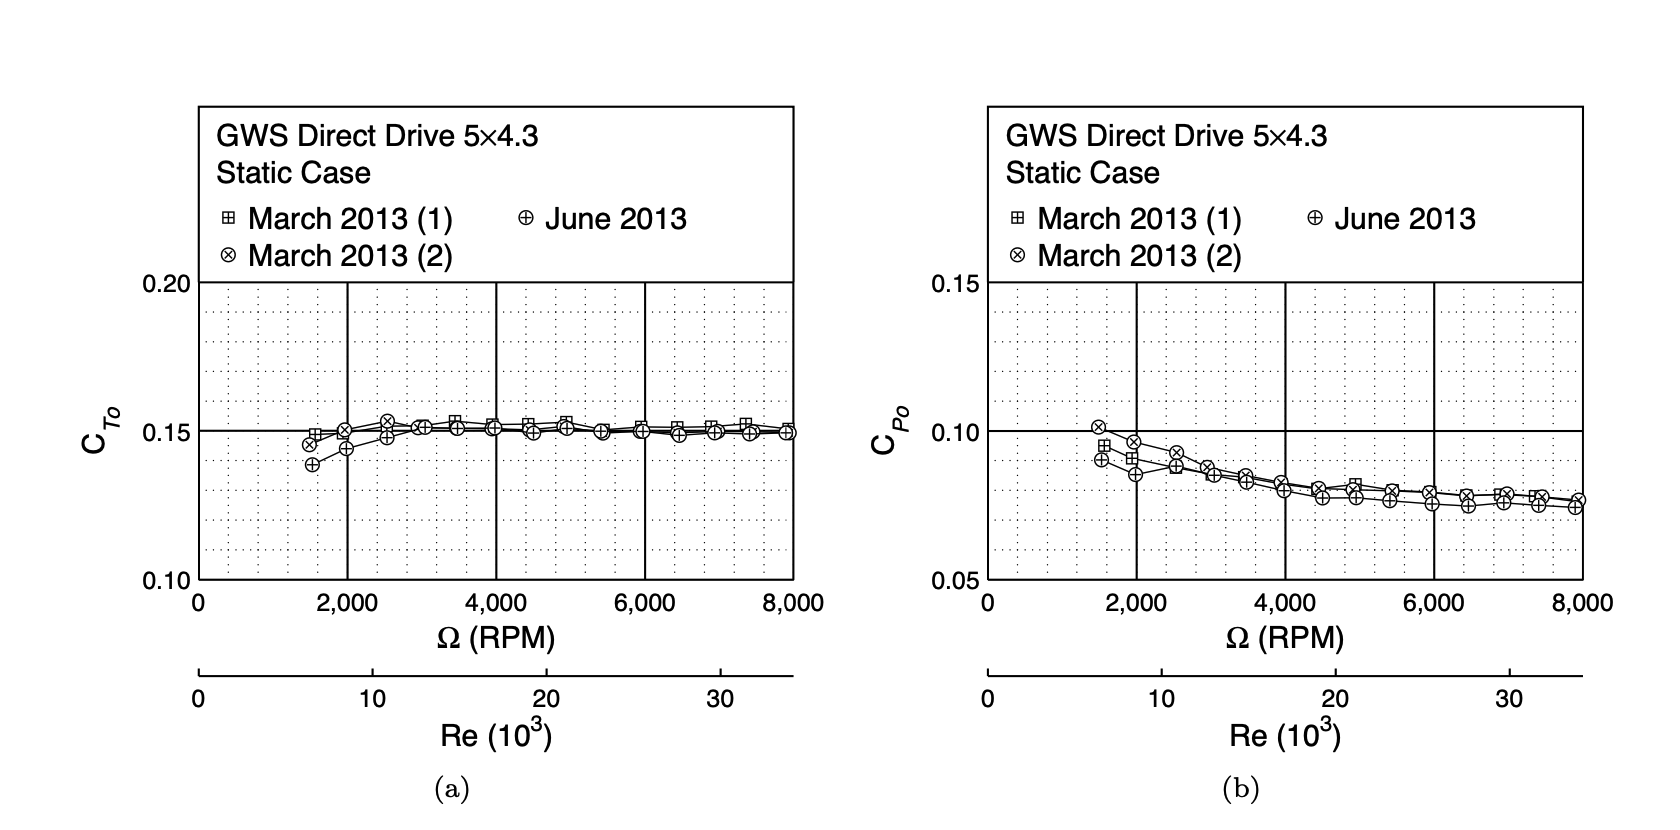

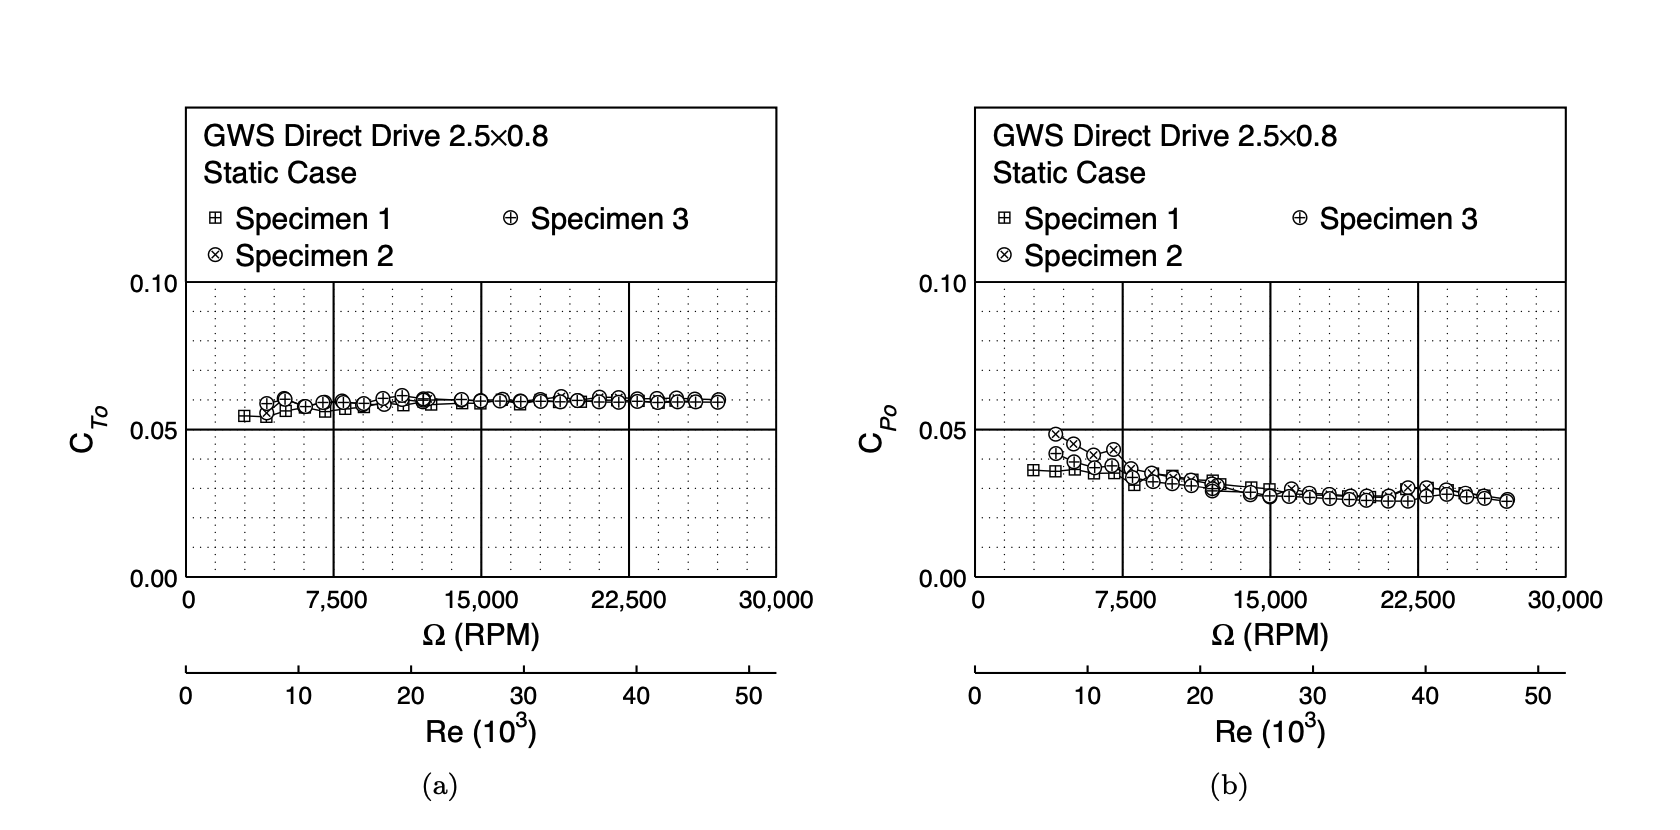

Source: https://m-selig.ae.illinois.edu/pubs/DetersAnandaSelig-2014-AIAA-2014-2151.pdf

Example: for $D=$5" (127mm) propellers, $T_{M1}=5N$ $T_{M2}=4N$: 


$$ \Delta\tau_{M1-M2} = 1.01\times10^{-2} Nm$$

In [ ]:
CpCt, D = sp.symbols(['CpCt', 'D'])

Thrust in the $B_1$ frame:

$$T_{B1} =\begin{bmatrix}
           T_{x} \\
           T_{y} \\
           T_z 
         \end{bmatrix}$$
         
         

can be found through trigonometry where:

$\phi_{Tx}$ : the rotation of the thrust vector around the x-axis  
$\phi_{Ty}$ : the rotation of the thrust vector around the y-axis

The conversion matrix is:

In [ ]:
# Thrust in the $B_1$ frame:
Thrust_to_B1_cartesian = sp.Matrix([sp.cos(thrust_angle_x)*sp.sin(thrust_angle_y), 
                 -sp.cos(thrust_angle_y)*sp.sin(thrust_angle_x), 
                 +sp.cos(thrust_angle_y)*sp.cos(thrust_angle_x)],
               )
Thrust_to_B1_cartesian

⎡sin(φ_Ty)⋅cos(φ_Tx) ⎤
⎢                    ⎥
⎢-sin(φ_Tx)⋅cos(φ_Ty)⎥
⎢                    ⎥
⎣cos(φ_Tx)⋅cos(φ_Ty) ⎦

In [ ]:
Tb1 = (Tm1+Tm2)*Thrust_to_B1_cartesian
Tb1

⎡(T_M1 + T_M2)⋅sin(φ_Ty)⋅cos(φ_Tx) ⎤
⎢                                  ⎥
⎢-(T_M1 + T_M2)⋅sin(φ_Tx)⋅cos(φ_Ty)⎥
⎢                                  ⎥
⎣(T_M1 + T_M2)⋅cos(φ_Tx)⋅cos(φ_Ty) ⎦

In [ ]:
# Test using thrust_angle_x:0, thrust_angle_y:0, Tm1:0.5, Tm2:0.5
Tb1.subs({thrust_angle_x:0, thrust_angle_y:0, Tm1:0.5, Tm2:0.5})

⎡ 0 ⎤
⎢   ⎥
⎢ 0 ⎥
⎢   ⎥
⎣1.0⎦

In [ ]:
# Test using thrust_angle_x:0, thrust_angle_y:0.1, Tm1:0.5, Tm2:0.5
Tb1.subs({thrust_angle_x:0, thrust_angle_y:sp.pi/6, Tm1:0.5, Tm2:0.5})

⎡ 0.5  ⎤
⎢      ⎥
⎢  0   ⎥
⎢      ⎥
⎣0.5⋅√3⎦

In [ ]:
# Test using thrust_angle_x:sp.pi/6, thrust_angle_y:0.1, Tm1:0.5, Tm2:0.5
Tb1.subs({thrust_angle_x:sp.pi/6, thrust_angle_y:0, Tm1:0.5, Tm2:0.5})

⎡  0   ⎤
⎢      ⎥
⎢ -0.5 ⎥
⎢      ⎥
⎣0.5⋅√3⎦

In [ ]:
# Test using thrust_angle_x:0.1, thrust_angle_y:0.1, Tm1:0.5, Tm2:0.5
Tb1.subs({thrust_angle_x:0.1, thrust_angle_y:0.1, Tm1:0.5, Tm2:0.5})

⎡0.0993346653975306 ⎤
⎢                   ⎥
⎢-0.0993346653975306⎥
⎢                   ⎥
⎣ 0.990033288920621 ⎦


The thrust vector in $N(B_1)$ frame can be transformed into the $N(B)$ frame as follows:

Thrust throught the Center of Mass:
$$\vec{T_b} = \vec{T_{b1}}$$ and 

Torque in the $N(b)$ frame:
$$M_b = \vec{b} \times \vec{T_{b1}}$$

## Forces acting on $N(B)$

In [ ]:
Tbb = Tb1
Tbb

⎡(T_M1 + T_M2)⋅sin(φ_Ty)⋅cos(φ_Tx) ⎤
⎢                                  ⎥
⎢-(T_M1 + T_M2)⋅sin(φ_Tx)⋅cos(φ_Ty)⎥
⎢                                  ⎥
⎣(T_M1 + T_M2)⋅cos(φ_Tx)⋅cos(φ_Ty) ⎦

## Moments (torque) about $N(B)$ 


Check: if $T_{M1}$ and $T_{M2}$ are positive then the force exerted on the rocket should be in the positive z-direction.  The last term of the above vector is the component in the z-direction and will be positive for positive $T_{M1}$ and $T_{M2}$

In [ ]:
# b is the vector between the B and B1 coordinate systems
motor_to_cm = sp.symbols('d_m') # in the positive z-direction
b=sp.Matrix([0,0,-motor_to_cm])
b

⎡ 0 ⎤
⎢   ⎥
⎢ 0 ⎥
⎢   ⎥
⎣-dₘ⎦

First calcluate the torque of the thrust $T$ about the $N(B)$ frame (center of mass)

$$ M_B = b \times T_{B1} $$

In [ ]:
Mb_thrust_vector =b.cross(Tb1)
Mb_thrust_vector

⎡-dₘ⋅(T_M1 + T_M2)⋅sin(φ_Tx)⋅cos(φ_Ty)⎤
⎢                                     ⎥
⎢-dₘ⋅(T_M1 + T_M2)⋅sin(φ_Ty)⋅cos(φ_Tx)⎥
⎢                                     ⎥
⎣                  0                  ⎦

Add the torqe arising from the differential motor thrust from equation (7) above:
$$ \tau = -\frac{D C_P }{2 \pi C_T}(T_{M1}- T_{M2}) \tag{7}$$

This torque vector is aligned with the thrust vector and will have components in $x,y,z$ directions.



In [ ]:
Mb_motor_torque = -CpCt*D*(-Tm2+Tm1)/(2*sp.pi)*Thrust_to_B1_cartesian
Mb_motor_torque

⎡-CpCt⋅D⋅(T_M1 - T_M2)⋅sin(φ_Ty)⋅cos(φ_Tx) ⎤
⎢──────────────────────────────────────────⎥
⎢                   2⋅π                    ⎥
⎢                                          ⎥
⎢ CpCt⋅D⋅(T_M1 - T_M2)⋅sin(φ_Tx)⋅cos(φ_Ty) ⎥
⎢ ──────────────────────────────────────── ⎥
⎢                   2⋅π                    ⎥
⎢                                          ⎥
⎢-CpCt⋅D⋅(T_M1 - T_M2)⋅cos(φ_Tx)⋅cos(φ_Ty) ⎥
⎢──────────────────────────────────────────⎥
⎣                   2⋅π                    ⎦

In [ ]:
Mb = Mb_thrust_vector + Mb_motor_torque
Mb

⎡  CpCt⋅D⋅(T_M1 - T_M2)⋅sin(φ_Ty)⋅cos(φ_Tx)                                   
⎢- ──────────────────────────────────────── - dₘ⋅(T_M1 + T_M2)⋅sin(φ_Tx)⋅cos(φ
⎢                    2⋅π                                                      
⎢                                                                             
⎢ CpCt⋅D⋅(T_M1 - T_M2)⋅sin(φ_Tx)⋅cos(φ_Ty)                                    
⎢ ──────────────────────────────────────── - dₘ⋅(T_M1 + T_M2)⋅sin(φ_Ty)⋅cos(φ_
⎢                   2⋅π                                                       
⎢                                                                             
⎢                   -CpCt⋅D⋅(T_M1 - T_M2)⋅cos(φ_Tx)⋅cos(φ_Ty)                 
⎢                   ──────────────────────────────────────────                
⎣                                      2⋅π                                    

    ⎤
_Ty)⎥
    ⎥
    ⎥
    ⎥
Tx) ⎥
    ⎥
    ⎥
    ⎥
    ⎥
    ⎦

In [ ]:
# Check 90 degree Theta_x Tm1 = Tm2 = Tm
Mb.subs({thrust_angle_x:sp.pi/2, thrust_angle_y:0, Tm2:Tm, Tm1:Tm})

⎡-2⋅T_M⋅dₘ⎤
⎢         ⎥
⎢    0    ⎥
⎢         ⎥
⎣    0    ⎦

In [ ]:
# Check 30 degree Theta_y
Mb.subs({thrust_angle_x:0, thrust_angle_y:sp.pi/2, Tm2:Tm, Tm1:Tm})

⎡    0    ⎤
⎢         ⎥
⎢-2⋅T_M⋅dₘ⎥
⎢         ⎥
⎣    0    ⎦

In [ ]:
# Check 30 degree Theta_x and Theta_y
Mb.subs({thrust_angle_x:sp.pi/6, thrust_angle_y:sp.pi/6,Tm2:Tm, Tm1:Tm})

⎡-√3⋅T_M⋅dₘ ⎤
⎢───────────⎥
⎢     2     ⎥
⎢           ⎥
⎢-√3⋅T_M⋅dₘ ⎥
⎢───────────⎥
⎢     2     ⎥
⎢           ⎥
⎣     0     ⎦

In [ ]:
# Check 0 degree Theta_x and Theta_y Tm1=5, Tm2=4 , D=0.127 CpCt=0.5
Mb.subs({thrust_angle_x:0, thrust_angle_y:0,Tm2:4, Tm1:6, D:0.127, CpCt:0.5})

⎡   0    ⎤
⎢        ⎥
⎢   0    ⎥
⎢        ⎥
⎢-0.0635 ⎥
⎢────────⎥
⎣   π    ⎦

In [ ]:
# Check  Theta_x:0 and Theta_y=90 Tm1=-1, Tm2=1 , D=0.127 CpCt=0.5
Mb.subs({thrust_angle_x:0, thrust_angle_y:sp.pi/2,Tm2:1, Tm1:-1, D:0.127, CpCt:0.5})

⎡0.0635⎤
⎢──────⎥
⎢  π   ⎥
⎢      ⎥
⎢  0   ⎥
⎢      ⎥
⎣  0   ⎦

In [ ]:
# Check 0 degree Theta_x and Theta_y Tm1=5, Tm2=4 , D=0.127 CpCt=0.5
Mb.subs({thrust_angle_x:sp.pi/3, thrust_angle_y:sp.pi/3, Tm2:4, Tm1:5, D:0.127, CpCt:0.5})

⎡  9⋅√3⋅dₘ   0.0079375⋅√3⎤
⎢- ─────── - ────────────⎥
⎢     4           π      ⎥
⎢                        ⎥
⎢  9⋅√3⋅dₘ   0.0079375⋅√3⎥
⎢- ─────── + ────────────⎥
⎢     4           π      ⎥
⎢                        ⎥
⎢      -0.0079375        ⎥
⎢      ───────────       ⎥
⎣           π            ⎦

In [ ]:
sp.N(Mb.subs({thrust_angle_x:sp.pi/6, thrust_angle_y:sp.pi/6,
              Tm2:4, Tm1:5, 
              D:0.127, CpCt:0.5, motor_to_cm:0.5}))

⎡  -1.9529333316224  ⎤
⎢                    ⎥
⎢ -1.94418098540758  ⎥
⎢                    ⎥
⎣-0.00757975416475152⎦

# Rocket equations of motion

From Newton's Second Law for linear motion:
$$\vec{F} = m\frac{d}{dt}\vec{V}\tag{9}$$

where $\vec{F}$ is the force vector, $m$ is the mass and $\vec{V}$ is the velocity vector.


Similarly, 

$$\vec{M} = \frac{d}{dt}\vec{H}\tag{10}$$

Note: these laws are only valid in an inertial (non-rotating and non-accelerating) coodinate system.

where $\vec{M}$ is the moment vector and $\vec{H}$ is the angular momentum. 

If a body-fixed frame is rotating with rotation vector $\vec{\omega_I}$ relative to the intertial frame, then for any vector $\vec{a}$ in the inertial frame: 
$$\frac{d\vec{a}}{dt}\vert_I = \frac{d\vec{a}}{dt}\vert_B + \vec{\omega} \times \vec{a}\tag{12}$$

Applying (12) to (9) and (10):

$$\vec{F} = m\frac{d\vec{V}}{dt}\vert_B + m (\vec{\omega} \times  \vec{V})\tag{13}$$

$$\vec{M} = \frac{d\vec{H}}{dt}\vert_B + \vec{\omega} \times  \vec{H}\tag{14}$$



Solving for the derivatives:

$$ \frac{d\vec{V}}{dt}\vert_B = \frac{1}{m} \vec{F} -  (\vec{\omega} \times  \vec{V})\tag{15}$$ 

and 

$$\frac{d\vec{H}}{dt}\vert_B = \vec{M}  - \vec{\omega} \times  \vec{H}\tag{16}$$

### Linear equations of motion
The challenge is to find the equations of motion in the rotating reference frame. Equation (15) shows how this can be achieved.  The steps are as follows:
1. The gravitational force must be converted into the body coordinates based on the attitude of the body frame
2. The thrust must be calculated based on Tm1, Tm2, ThrustTheta and ThrustPhi (
3. The velocity in the interial coordinates must be calculated from the rotated velocity in the body coordinates


In [ ]:
omega, V, F, dVdt, m, g = sp.symbols(['omega', 'V', 'F', 'dVdt', 'm', 'g'])
u, v, w = sp.symbols('u,v,w')
p, q, r = sp.symbols('p,q,r')
Fx, Fy, Fz = sp.symbols('F_x, F_y, F_z')

In [ ]:
# Thrust in the body frame
Tbb

⎡(T_M1 + T_M2)⋅sin(φ_Ty)⋅cos(φ_Tx) ⎤
⎢                                  ⎥
⎢-(T_M1 + T_M2)⋅sin(φ_Tx)⋅cos(φ_Ty)⎥
⎢                                  ⎥
⎣(T_M1 + T_M2)⋅cos(φ_Tx)⋅cos(φ_Ty) ⎦

In [ ]:
V = sp.Matrix([u, v, w])
V

⎡u⎤
⎢ ⎥
⎢v⎥
⎢ ⎥
⎣w⎦

In [ ]:
omega = sp.Matrix([p, q, r])
omega

⎡p⎤
⎢ ⎥
⎢q⎥
⎢ ⎥
⎣r⎦

In [ ]:
F = sp.Matrix([Fx, Fy, Fz])
F

⎡Fₓ ⎤
⎢   ⎥
⎢F_y⎥
⎢   ⎥
⎣F_z⎦

## Add the gravity vector

The gravity vector is in the inertial frame and must be converted into the body frame. 

How? try using the built in sympy refrence frame functions and euler angles


In [ ]:
from sympy.physics.vector import *
# create the Global frame
G = ReferenceFrame('G')

In [ ]:
# create the Body frame
B = ReferenceFrame('B')

In [ ]:
# define the symbols for rol-pitch-yaw
theta_roll, theta_pitch, theta_yaw = sp.symbols(['theta_roll', 'theta_pitch', 'theta_yaw'])
theta_roll, theta_pitch, theta_yaw

(θᵣₒₗₗ, θ_pitch, θ_yaw)

In [ ]:
# create a vector in the body coords for testing
v = 0 * B.x + 0 * B.y + 1 * B.z

### Inertial (G) to body (B)

In [ ]:
# this creates the cosine matrix for the rol-pitch-yaw transformation 
B.orient_body_fixed(G,[theta_roll , theta_pitch, theta_yaw], '123')

In [ ]:
Cosine_I2B = B.dcm(G).copy()
Cosine_I2B

⎡cos(θ_pitch)⋅cos(θ_yaw)   sin(θ_pitch)⋅sin(θᵣₒₗₗ)⋅cos(θ_yaw) + sin(θ_yaw)⋅cos
⎢                                                                             
⎢-sin(θ_yaw)⋅cos(θ_pitch)  -sin(θ_pitch)⋅sin(θᵣₒₗₗ)⋅sin(θ_yaw) + cos(θᵣₒₗₗ)⋅co
⎢                                                                             
⎣      sin(θ_pitch)                         -sin(θᵣₒₗₗ)⋅cos(θ_pitch)          

(θᵣₒₗₗ)   -sin(θ_pitch)⋅cos(θᵣₒₗₗ)⋅cos(θ_yaw) + sin(θᵣₒₗₗ)⋅sin(θ_yaw)⎤
                                                                     ⎥
s(θ_yaw)  sin(θ_pitch)⋅sin(θ_yaw)⋅cos(θᵣₒₗₗ) + sin(θᵣₒₗₗ)⋅cos(θ_yaw) ⎥
                                                                     ⎥
                            cos(θ_pitch)⋅cos(θᵣₒₗₗ)                  ⎦

In [ ]:
# roll 90 deg around x then 90 pitch
Cosine_I2B.subs({theta_roll:np.pi/2, theta_pitch:0, theta_yaw:np.pi/2})*sp.Matrix([0,0,-1])

⎡        -1.0         ⎤
⎢                     ⎥
⎢-6.12323399573677e-17⎥
⎢                     ⎥
⎣-6.12323399573677e-17⎦

In [ ]:
# roll 90 deg around x then 90 pitch
Cosine_I2B.subs({theta_roll:np.pi/2, theta_pitch:np.pi/2, theta_yaw:0})*sp.Matrix([0,0,1])

⎡-6.12323399573677e-17⎤
⎢                     ⎥
⎢         1.0         ⎥
⎢                     ⎥
⎣3.74939945665464e-33 ⎦

In [ ]:
# roll 30 deg around x
Cosine_I2B.subs({theta_roll:sp.pi/6, theta_pitch:0, theta_yaw:0})*sp.Matrix([0,0,1])

⎡ 0 ⎤
⎢   ⎥
⎢1/2⎥
⎢   ⎥
⎢√3 ⎥
⎢── ⎥
⎣2  ⎦

In [ ]:
# roll 30 deg around y
Cosine_I2B.subs({theta_roll:0, theta_pitch:sp.pi/6, theta_yaw:0})*sp.Matrix([0,0,1])

⎡-1/2⎤
⎢    ⎥
⎢ 0  ⎥
⎢    ⎥
⎢ √3 ⎥
⎢ ── ⎥
⎣ 2  ⎦

In [ ]:
# roll 30 deg around yaw
Cosine_I2B.subs({theta_roll:0, theta_pitch:0, theta_yaw:sp.pi/6})*sp.Matrix([0,0,1])

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣1⎦

In [ ]:
# roll 30 deg around x,y
Cosine_I2B.subs({theta_roll:sp.pi/6, theta_pitch:sp.pi/6, theta_yaw:0})*sp.Matrix([0,0,1])

⎡-√3 ⎤
⎢────⎥
⎢ 4  ⎥
⎢    ⎥
⎢1/2 ⎥
⎢    ⎥
⎣3/4 ⎦

In [ ]:
# roll 30 deg around y
Cosine_I2B.subs({theta_roll:0, theta_pitch:sp.pi/6, theta_yaw:0})*sp.Matrix([1,0,0])

⎡√3 ⎤
⎢── ⎥
⎢2  ⎥
⎢   ⎥
⎢ 0 ⎥
⎢   ⎥
⎣1/2⎦

### Body (B) to Inertial (G)

This is $^BC^G$

In [ ]:
Cosine_B2I = G.dcm(B).copy()
Cosine_B2I

⎡                  cos(θ_pitch)⋅cos(θ_yaw)                                    
⎢                                                                             
⎢sin(θ_pitch)⋅sin(θᵣₒₗₗ)⋅cos(θ_yaw) + sin(θ_yaw)⋅cos(θᵣₒₗₗ)   -sin(θ_pitch)⋅si
⎢                                                                             
⎣-sin(θ_pitch)⋅cos(θᵣₒₗₗ)⋅cos(θ_yaw) + sin(θᵣₒₗₗ)⋅sin(θ_yaw)  sin(θ_pitch)⋅sin

 -sin(θ_yaw)⋅cos(θ_pitch)                          sin(θ_pitch)      ⎤
                                                                     ⎥
n(θᵣₒₗₗ)⋅sin(θ_yaw) + cos(θᵣₒₗₗ)⋅cos(θ_yaw)  -sin(θᵣₒₗₗ)⋅cos(θ_pitch)⎥
                                                                     ⎥
(θ_yaw)⋅cos(θᵣₒₗₗ) + sin(θᵣₒₗₗ)⋅cos(θ_yaw)   cos(θ_pitch)⋅cos(θᵣₒₗₗ) ⎦

In [ ]:
# Test, convert to body and back this should return the original vector for all rotations
rot = {theta_roll:np.pi, theta_pitch:np.pi/2, theta_yaw:.3}
Cosine_B2I.subs(rot)*Cosine_I2B.subs(rot)*sp.Matrix([10,1,1])

⎡10.0⎤
⎢    ⎥
⎢1.0 ⎥
⎢    ⎥
⎣1.0 ⎦

In [ ]:
# roll 90 deg around x then 90 pitch
Cosine_B2I.subs({theta_roll:np.pi/2, theta_pitch:np.pi/2, theta_yaw:np.pi/2})*sp.Matrix([0,0,1])

⎡         1.0         ⎤
⎢                     ⎥
⎢-6.12323399573677e-17⎥
⎢                     ⎥
⎣3.74939945665464e-33 ⎦

In [ ]:
Cosine_B2I_eval = sp.lambdify((theta_roll, theta_pitch, theta_yaw), Cosine_B2I, 'numpy')

In [ ]:
? Cosine_B2I_eval

Signature:  Cosine_B2I_eval(theta_roll, theta_pitch, theta_yaw)
Docstring:
Created with lambdify. Signature:

func(theta_roll, theta_pitch, theta_yaw)

Expression:

Matrix([[cos(theta_pitch)*cos(theta_yaw), -sin(theta_yaw)*cos(theta_pitch),...

Source code:

def _lambdifygenerated(theta_roll, theta_pitch, theta_yaw):
    return array([[cos(theta_pitch)*cos(theta_yaw), -sin(theta_yaw)*cos(theta_pitch), sin(theta_pitch)], [sin(theta_pitch)*sin(theta_roll)*cos(theta_yaw) + sin(theta_yaw)*cos(theta_roll), -sin(theta_pitch)*sin(theta_roll)*sin(theta_yaw) + cos(theta_roll)*cos(theta_yaw), -sin(theta_roll)*cos(theta_pitch)], [-sin(theta_pitch)*cos(theta_roll)*cos(theta_yaw) + sin(theta_roll)*sin(theta_yaw), sin(theta_pitch)*sin(theta_yaw)*cos(theta_roll) + sin(theta_roll)*cos(theta_yaw), cos(theta_pitch)*cos(theta_roll)]])


Imported modules:
File:      ~/Documents/rocket-democracy/dynamic_model/<lambdifygenerated-1>
Type:      function


### Test

In [ ]:
# roll 30 deg around x
Cosine_B2I.subs({theta_roll:sp.pi/6, theta_pitch:0, theta_yaw:0})*sp.Matrix([0,0,1])

⎡ 0  ⎤
⎢    ⎥
⎢-1/2⎥
⎢    ⎥
⎢ √3 ⎥
⎢ ── ⎥
⎣ 2  ⎦

In [ ]:
# pitch 30 deg around y
Cosine_B2I.subs({theta_roll:0, theta_pitch:sp.pi/6, theta_yaw:0})*sp.Matrix([0,0,1])

⎡1/2⎤
⎢   ⎥
⎢ 0 ⎥
⎢   ⎥
⎢√3 ⎥
⎢── ⎥
⎣2  ⎦

In [ ]:
# roll 30 deg around z
Cosine_B2I.subs({theta_roll:0, theta_pitch:0, theta_yaw:sp.pi/6})*sp.Matrix([0,0,1])

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣1⎦

In [ ]:
# roll 30 deg around x,y
Cosine_B2I.subs({theta_roll:sp.pi/6, theta_pitch:sp.pi/6, theta_yaw:0})*sp.Matrix([0,0,1])

⎡1/2 ⎤
⎢    ⎥
⎢-√3 ⎥
⎢────⎥
⎢ 4  ⎥
⎢    ⎥
⎣3/4 ⎦

In [ ]:
# roll 30 deg around x
Cosine_B2I.subs({theta_roll:sp.pi/6, theta_pitch:0, theta_yaw:0})*sp.Matrix([0,1,0])

⎡ 0 ⎤
⎢   ⎥
⎢√3 ⎥
⎢── ⎥
⎢2  ⎥
⎢   ⎥
⎣1/2⎦

In [ ]:
# roll 30 deg around y
Cosine_B2I.subs({theta_roll:0, theta_pitch:sp.pi/6, theta_yaw:0})*sp.Matrix([1,0,0])

⎡ √3 ⎤
⎢ ── ⎥
⎢ 2  ⎥
⎢    ⎥
⎢ 0  ⎥
⎢    ⎥
⎣-1/2⎦

In [ ]:
# roll 90 deg around x 90 around z
Cosine_B2I.subs({theta_roll:np.pi/2, theta_pitch:0, theta_yaw:np.pi/2})*sp.Matrix([1,0,0])

⎡6.12323399573677e-17⎤
⎢                    ⎥
⎢6.12323399573677e-17⎥
⎢                    ⎥
⎣        1.0         ⎦

## Rotate gravity vector in body coords

In [ ]:
# Add the gravity vector here
# need to define inertial and body reference frames and use vector functions

Tgg =sp.Matrix([0,0,-m*g])

The gavity vector $T^I_g$ is in the inertial coordinate system it mus be converted to the body coordinate system

$$T^B_g =  ^IC^B \times T^I_g$$

where $^IC^B$ is the Inertial to Body Cosine Matrix

In [ ]:
Tgb = Cosine_I2B*Tgg
Tgb

⎡-g⋅m⋅(-sin(θ_pitch)⋅cos(θᵣₒₗₗ)⋅cos(θ_yaw) + sin(θᵣₒₗₗ)⋅sin(θ_yaw))⎤
⎢                                                                  ⎥
⎢-g⋅m⋅(sin(θ_pitch)⋅sin(θ_yaw)⋅cos(θᵣₒₗₗ) + sin(θᵣₒₗₗ)⋅cos(θ_yaw)) ⎥
⎢                                                                  ⎥
⎣                   -g⋅m⋅cos(θ_pitch)⋅cos(θᵣₒₗₗ)                   ⎦

In [ ]:
F = Tbb + Tgb
F

⎡-g⋅m⋅(-sin(θ_pitch)⋅cos(θᵣₒₗₗ)⋅cos(θ_yaw) + sin(θᵣₒₗₗ)⋅sin(θ_yaw)) + (T_M1 + 
⎢                                                                             
⎢-g⋅m⋅(sin(θ_pitch)⋅sin(θ_yaw)⋅cos(θᵣₒₗₗ) + sin(θᵣₒₗₗ)⋅cos(θ_yaw)) - (T_M1 + T
⎢                                                                             
⎣                   -g⋅m⋅cos(θ_pitch)⋅cos(θᵣₒₗₗ) + (T_M1 + T_M2)⋅cos(φ_Tx)⋅cos

T_M2)⋅sin(φ_Ty)⋅cos(φ_Tx)⎤
                         ⎥
_M2)⋅sin(φ_Tx)⋅cos(φ_Ty) ⎥
                         ⎥
(φ_Ty)                   ⎦

In [ ]:
F_eval = sp.lambdify((Tm1, Tm2, thrust_angle_x, thrust_angle_y, 
                      theta_roll, theta_pitch, theta_yaw,
                      g, m), F)

In [ ]:
? F_eval

Signature:
 F_eval(
    T_M1,
    T_M2,
    phi_Tx,
    phi_Ty,
    theta_roll,
    theta_pitch,
    theta_yaw,
    g,
    m,
)
Docstring:
Created with lambdify. Signature:

func(T_M1, T_M2, phi_Tx, phi_Ty, theta_roll, theta_pitch, theta_yaw,
        g, m)

Expression:

Matrix([[-g*m*(-sin(theta_pitch)*cos(theta_roll)*cos(theta_yaw) +...

Source code:

def _lambdifygenerated(T_M1, T_M2, phi_Tx, phi_Ty, theta_roll, theta_pitch, theta_yaw, g, m):
    return array([[-g*m*(-sin(theta_pitch)*cos(theta_roll)*cos(theta_yaw) + sin(theta_roll)*sin(theta_yaw)) + (T_M1 + T_M2)*sin(phi_Ty)*cos(phi_Tx)], [-g*m*(sin(theta_pitch)*sin(theta_yaw)*cos(theta_roll) + sin(theta_roll)*cos(theta_yaw)) - (T_M1 + T_M2)*sin(phi_Tx)*cos(phi_Ty)], [-g*m*cos(theta_pitch)*cos(theta_roll) + (T_M1 + T_M2)*cos(phi_Tx)*cos(phi_Ty)]])


Imported modules:
File:      ~/Documents/rocket-democracy/dynamic_model/<lambdifygenerated-2>
Type:      function


In [ ]:
F_eval(5,5,0,0,0,0,0,g=9.81,m=1)

array([[ 0.  ],
       [-0.  ],
       [ 0.19]])

In [ ]:
#rocket rolls 30 deg 
F_eval(0,0,0,0,0,np.pi/6,0,g=10,m=1)

array([[ 5.        ],
       [-0.        ],
       [-8.66025404]])

In [ ]:
Ftot = sp.MatrixSymbol('F_tot', 3, 1)

In [ ]:
dVdt = (Ftot/m)-omega.cross(V)
dVdt

         ⎡-q⋅w + r⋅v⎤
1        ⎢          ⎥
─⋅Fₜₒₜ + ⎢p⋅w - r⋅u ⎥
m        ⎢          ⎥
         ⎣-p⋅v + q⋅u⎦

In [ ]:
dVdt_eval = sp.lambdify((Ftot, V, omega, m), dVdt, 'numpy')

In [ ]:
dVdt_eval(F_eval(0,0,0,0,0,np.pi/6,0,g=1,m=1), np.array([0,0,-1]), np.array([2,0,0]), 1) 

array([[ 0.5      ],
       [-2.       ],
       [-0.8660254]])

In [ ]:
? dVdt_eval

Signature:  dVdt_eval(F_tot, _Dummy_25, _Dummy_26, m)
Docstring:
Created with lambdify. Signature:

func(F_tot, arg_1, arg_2, m)

Expression:

Matrix([
[-q*w + r*v],
[ p*w - r*u],
[-p*v + q*u]]) + 1/m*F_tot

Source code:

def _lambdifygenerated(F_tot, _Dummy_25, _Dummy_26, m):
    [u, v, w] = _Dummy_25
    [p, q, r] = _Dummy_26
    return array([[-q*w + r*v], [p*w - r*u], [-p*v + q*u]]) + (F_tot).dot(m**(-1.0))


Imported modules:
File:      ~/Documents/rocket-democracy/dynamic_model/<lambdifygenerated-3>
Type:      function


Pulling it all together:

From equation (15): 
$$ \frac{d\vec{V}}{dt}\vert_B = \frac{1}{m} \vec{F} -  (\vec{\omega} \times  \vec{V})\tag{15}$$ 

This is cacluated by the function:  
`dVdt_eval = sp.lambdify((Ftot, V, omega, m), dVdt, 'numpy')`

Ftot is the total of the forces acting on the rocket though the CG and is calculated from the gravity vector and the thrust vector using:  
`Ftot = F_eval(T_M1, T_M2, phi_Tx, phi_Ty, theta_roll, theta_pitch, theta_yaw, g, m)`

This differential equation represents the equations of motion in the body coordinate frame. The state vector is defined in body coordinates as:

$$ state=\begin{bmatrix}
         \dot{x}\\
         \dot{y}\\
         \dot{z}\\
         x\\
         y\\
         z
         \end{bmatrix} $$

The $x,y,z$ positons in the body frame are not useful in the case that the rocket body frame rotates with respect to the global inertial frame.  However they will be used to test the linear quations of motion. 

Ultimately, it will be necessary to convert the rocket position into inertial coordiantes. This is not difficult. If the position in the global coordinate system $X^G$ then $X^G$ can be found by recognizing that $$\frac{dX_G}{dt}$$ can be found by rotating the veloicty vector in the body coordinate system to the global coordinate sytem using the Body-to-Inertial Cosine matrix and then integrating $\frac{dX_G}{dt}$ to get rocket position in the global coordinate system:

$$\frac{dX_G}{dt} = ^BC^G  \begin{bmatrix}
         \dot{x}\\
         \dot{y}\\
         \dot{z}
         \end{bmatrix} $$

In [ ]:
def rocket_linear(t, state, g, m):
  ddt = np.zeros(6)
  # temporary remove for full state system
  theta_roll = 0
  theta_pitch = 0
  theta_yaw = 0
  
  if t < 0.3:
    phi_Tx = 0.2
  else: 
    phi_Tx = -0.1

  if t < 1.:
    T_M1 = 15
    T_M2 = 15
  else: 
    T_M1 = 0
    T_M2 = 0
    
  if t < 2:
    phi_Ty = .02
  elif t < 4:
    phi_Ty = -0.02
  else:
    phi_Ty = 0
    
  theta_roll = 0  # todo: update when state vector expands to include roll
  theta_pitch = 0  # todo: update when state vector expands to include roll
  theta_yaw = 0  # todo: update when state vector expands to include roll
  
  V = state[0:3]
  omega = np.zeros(3) # todo: update when state vector expands to include roll
  
  dVdt_ = dVdt_eval(F_eval(T_M1, T_M2, phi_Tx, phi_Ty, theta_roll, theta_pitch, theta_yaw, g, m), V, omega, m)   
  

  
  ddt[0:3] = dVdt_[:,0]
  ddt[3:6] = state[0:3]   # the integrator 

  return ddt

In [ ]:
g_ = 9.81
T_M1 = 15
T_M2 = 15
phi_Tx = float(0) #0.0 #float(sp.N(sp.pi/6))
phi_Ty = float(0) # float(sp.N(sp.pi/6))
m_ = 1

params = ( g_, m_)


In [ ]:
# test the external forces function
F_eval(T_M1, T_M2, phi_Tx, phi_Ty, 0, 0, 0, g_, m_)

array([[ 0.  ],
       [-0.  ],
       [20.19]])

In [ ]:
dVdt_eval(F_eval(T_M1, T_M2, phi_Tx, phi_Ty, 0,0,0, g_, m_), np.zeros(3), np.zeros(3), m_)[:,0]

array([ 0.  ,  0.  , 20.19])

In [ ]:
y0 = np.array([0,0,0,0,0,0])
state = y0

In [ ]:
t_span = (0.0, 5.0)
t_eval = np.arange(0,5,0.01)

In [ ]:
from scipy.integrate import *
import matplotlib.pyplot as plt
result_solve_ivp = solve_ivp(rocket_linear, t_span, y0, t_eval=t_eval,
                             events=[], args=params, method='LSODA')

In [ ]:
import pandas as pd
state_labels = ['V_x', 'V_y', 'V_z', 'P_x', 'P_y', 'P_z' ]
resdf = pd.DataFrame(result_solve_ivp.y.T,columns=state_labels, index=result_solve_ivp.t)

In [ ]:
resdf

,V_x,V_y,V_z,P_x,P_y,P_z
0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.01,0.005880,-0.059589,0.195861,0.000029,-0.000298,0.000979
0.02,0.011760,-0.119178,0.391722,0.000118,-0.001192,0.003917
0.03,0.017640,-0.178767,0.587584,0.000265,-0.002681,0.008814
0.04,0.023520,-0.238356,0.783445,0.000470,-0.004767,0.015669
...,...,...,...,...,...,...
4.95,0.594269,0.308457,-18.850018,2.643748,0.433517,11.981896
4.96,0.594269,0.308457,-18.948118,2.649691,0.436602,11.792905
4.97,0.594269,0.308457,-19.046218,2.655634,0.439686,11.602934
4.98,0.594269,0.308457,-19.144318,2.661576,0.442771,11.411981


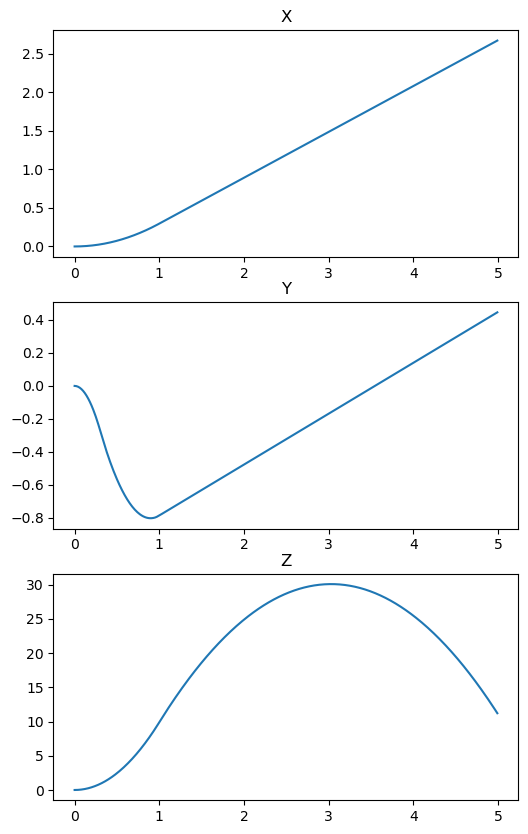

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(6,10))
ax[0].plot(resdf.index,resdf['P_x'])
ax[0].set_title('X')
ax[1].plot(resdf.index,resdf['P_y'])
ax[1].set_title('Y')
ax[2].plot(resdf.index,resdf['P_z'])
ax[2].set_title('Z')
plt.show()

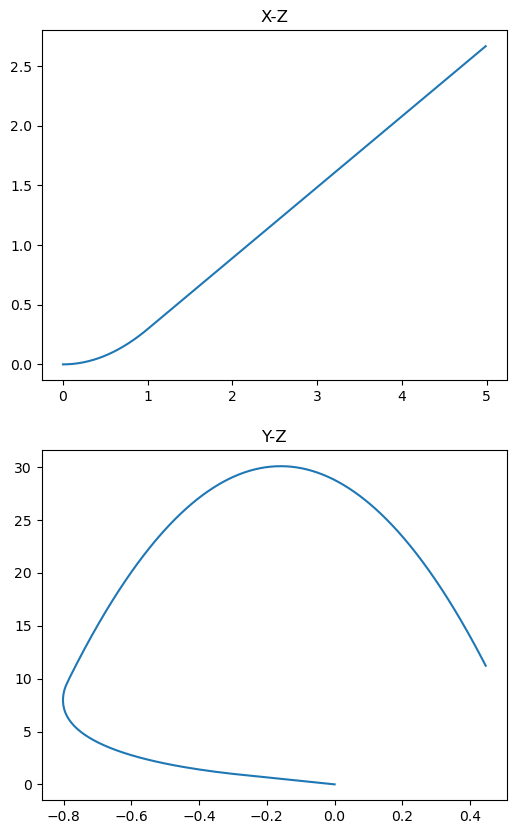

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(6,10))
ax[0].plot(resdf.index,resdf['P_x'])
ax[0].set_title('X-Z')
ax[1].plot(resdf['P_y'],resdf['P_z'])
ax[1].set_title('Y-Z')

plt.show()

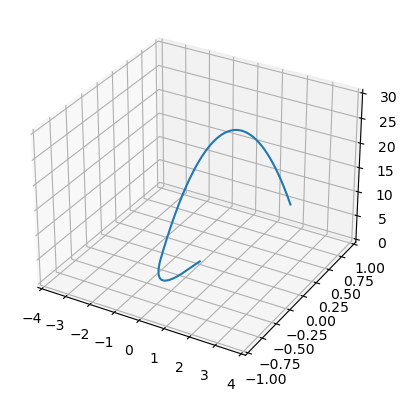

In [ ]:
ax = plt.figure().add_subplot(projection='3d')



ax.plot(resdf['P_x'], resdf['P_y'], resdf['P_z'])
ax.set_xlim([-4,4])
ax.set_ylim([-1,1])

plt.show()



Check this out for rotational bodies
https://ae640a.github.io/assets/winter17/slides/Lecture%203.pdf

## Include Angular equations of motion

From (14) :

$$\vec{M} = \frac{d\vec{H}}{dt}\vert_B + \vec{\omega} \times  \vec{H}\tag{14}$$

$$ \frac{d\vec{H}}{dt}\vert_B = \vec{M} - \vec{\omega} \times  \vec{H} \tag{16}$$



and 

$$\vec{H} = I\vec{\omega}$$

substituting into  (16)

$$ I \frac{d\vec{\omega}}{dt}\vert_B = \vec{M} - \vec{\omega} \times  I \vec{\omega} $$

$$ \frac{d\vec{\omega}}{dt}\vert_B = I^{-1}(\vec{M} - \vec{\omega} \times  I \vec{\omega}) \tag{17}$$



$$\omega = \begin{bmatrix}
         p \\
         q \\
         r
         \end{bmatrix}$$

In [ ]:
# Load the rocket inertia matrix:
import pickle
rocket_I = pickle.load(open('rocket_I.p', 'rb'))

In [ ]:
rocket_I

array([[0.116855439342949, 0, 0],
       [0, 0.116846023717949, 0],
       [0, 0, 0.00706014062500000]], dtype=object)

In [ ]:
rocket_I = np.eye(3)

In [ ]:
# this was created in the InertiaMatrix.ipynb notebook
rocket_I_inv = sp.Matrix(rocket_I).inv()

In [ ]:
rocket_I_inv


⎡1.0   0    0 ⎤
⎢             ⎥
⎢ 0   1.0   0 ⎥
⎢             ⎥
⎣ 0    0   1.0⎦

In [ ]:
Mb

⎡  CpCt⋅D⋅(T_M1 - T_M2)⋅sin(φ_Ty)⋅cos(φ_Tx)                                   
⎢- ──────────────────────────────────────── - dₘ⋅(T_M1 + T_M2)⋅sin(φ_Tx)⋅cos(φ
⎢                    2⋅π                                                      
⎢                                                                             
⎢ CpCt⋅D⋅(T_M1 - T_M2)⋅sin(φ_Tx)⋅cos(φ_Ty)                                    
⎢ ──────────────────────────────────────── - dₘ⋅(T_M1 + T_M2)⋅sin(φ_Ty)⋅cos(φ_
⎢                   2⋅π                                                       
⎢                                                                             
⎢                   -CpCt⋅D⋅(T_M1 - T_M2)⋅cos(φ_Tx)⋅cos(φ_Ty)                 
⎢                   ──────────────────────────────────────────                
⎣                                      2⋅π                                    

    ⎤
_Ty)⎥
    ⎥
    ⎥
    ⎥
Tx) ⎥
    ⎥
    ⎥
    ⎥
    ⎥
    ⎦

In [ ]:
rocket_I*sp.Matrix([p,q,r])

⎡1.0⋅p⎤
⎢     ⎥
⎢1.0⋅q⎥
⎢     ⎥
⎣1.0⋅r⎦

In [ ]:
sp.Matrix([p,q,r]).cross(rocket_I*sp.Matrix([p,q,r]))

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦

In [ ]:
rocket_I_inv * (sp.Matrix([p,q,r]).cross(rocket_I*sp.Matrix([p,q,r])))

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦

In [ ]:
d_omega_dt = rocket_I_inv * (Mb - sp.Matrix([p,q,r]).cross(rocket_I*sp.Matrix([p,q,r])))
d_omega_dt 

⎡  0.5⋅CpCt⋅D⋅(T_M1 - T_M2)⋅sin(φ_Ty)⋅cos(φ_Tx)                               
⎢- ──────────────────────────────────────────── - dₘ⋅(T_M1 + T_M2)⋅sin(φ_Tx)⋅c
⎢                       π                                                     
⎢                                                                             
⎢ 0.5⋅CpCt⋅D⋅(T_M1 - T_M2)⋅sin(φ_Tx)⋅cos(φ_Ty)                                
⎢ ──────────────────────────────────────────── - dₘ⋅(T_M1 + T_M2)⋅sin(φ_Ty)⋅co
⎢                      π                                                      
⎢                                                                             
⎢                   -0.5⋅CpCt⋅D⋅(T_M1 - T_M2)⋅cos(φ_Tx)⋅cos(φ_Ty)             
⎢                   ──────────────────────────────────────────────            
⎣                                         π                                   

        ⎤
os(φ_Ty)⎥
        ⎥
        ⎥
        ⎥
s(φ_Tx) ⎥
        ⎥
        ⎥
        ⎥
        ⎥
        ⎦

In [ ]:
d_omega_dt_eval = sp.lambdify((Tm1, Tm2, p, q, r, thrust_angle_x, thrust_angle_y, CpCt, motor_to_cm, D), d_omega_dt, 'numpy')


In [ ]:
? d_omega_dt_eval

Signature:  d_omega_dt_eval(T_M1, T_M2, p, q, r, phi_Tx, phi_Ty, CpCt, d_m, D)
Docstring:
Created with lambdify. Signature:

func(T_M1, T_M2, p, q, r, phi_Tx, phi_Ty, CpCt, d_m, D)

Expression:

Matrix([[-0.5*CpCt*D*(T_M1 - T_M2)*sin(phi_Ty)*cos(phi_Tx)/pi -...

Source code:

def _lambdifygenerated(T_M1, T_M2, p, q, r, phi_Tx, phi_Ty, CpCt, d_m, D):
    return array([[-0.5*CpCt*D*(T_M1 - T_M2)*sin(phi_Ty)*cos(phi_Tx)/pi - 1.0*d_m*(T_M1 + T_M2)*sin(phi_Tx)*cos(phi_Ty)], [0.5*CpCt*D*(T_M1 - T_M2)*sin(phi_Tx)*cos(phi_Ty)/pi - 1.0*d_m*(T_M1 + T_M2)*sin(phi_Ty)*cos(phi_Tx)], [-0.5*CpCt*D*(T_M1 - T_M2)*cos(phi_Tx)*cos(phi_Ty)/pi]])


Imported modules:
File:      ~/Documents/rocket-democracy/dynamic_model/<lambdifygenerated-4>
Type:      function


In [ ]:
# Test
d_omega_dt_eval(T_M1=5, T_M2=5, p=0, q=0, r=0, phi_Tx=np.pi/6, phi_Ty=0, CpCt=0.5, d_m=0.3, D=0.125)

array([[-1.5],
       [ 0. ],
       [-0. ]])

In [ ]:
# Test
d_omega_dt_eval(T_M1=5, T_M2=5, p=0, q=0, r=0, phi_Tx=0, phi_Ty=np.pi/6, CpCt=0.5, d_m=0.3, D=0.125)

array([[-0. ],
       [-1.5],
       [-0. ]])

In [ ]:
# Test
d_omega_dt_eval(T_M1=5.5, T_M2=4.5, p=0, q=0, r=0, phi_Tx=0, phi_Ty=0, CpCt=0.5, d_m=0.3, D=0.125)

array([[-0.        ],
       [ 0.        ],
       [-0.00994718]])

Expand the state vector to accommodate for the rotations. Since the rocket attitude is known the position in global coordinate system $(x_G,y_G,z_G)$ can be calculated.

$$ state=\begin{bmatrix}
         \dot{x}\\
         \dot{y}\\
         \dot{z}\\
         x_G\\
         y_G\\
         z_G\\
         \dot{\theta_x}\\
         \dot{\theta_y}\\
         \dot{\theta_z}\\
         \theta_x\\
         \theta_y\\
         \theta_z
         \end{bmatrix} = \begin{bmatrix}
         \dot{x}\\
         \dot{y}\\
         \dot{z}\\
         x_G\\
         y_G\\
         z_G\\
         p\\
         q\\
         r\\
         \theta_x\\
         \theta_y\\
         \theta_z
         \end{bmatrix}$$


In [ ]:
g_ = 9.81
m_ = 1
CpCt_ = 0.5
motor_to_cm_ = 0.3
D_ = 0.125
T_M1_ = 0
T_M2_ = 0
phi_Tx_ = 0
phi_Ty_ = 0


params =  ( g_, m_, CpCt_, motor_to_cm_, D_, None)

state_labels = ['V_x', 'V_y', 'V_z',                
                'G_x', 'G_y', 'G_z', 
                'p','q','r',
                'Theta_x','Theta_y','Theta_z' ]

# state index values in the state vector
st_Vx = 0
st_Vy = 1
st_Vz = 2
st_Gx = 3
st_Gy = 4
st_Gz = 5
st_p  = 6 
st_q  = 7
st_r  = 8
st_thetax = 9
st_thetay = 10
st_thetaz = 11


In [ ]:
def rocket_full(t, state, g, m, CpCt, d_m, D, control_callback):
  
  """Complete non-linear equations of motion for for a rocket with an optional control_callback function. If None 
  is passed as the control_callbak fuction, then parameter values of T_M1, T_M2, phi_Tx, phi_Ty are used.  If the
  callback is provided then the control parameters returned by the callback function will be used. 
  
  The callback function signature is :
  T_M1, T_M2, phi_Tx, phi_Ty = control_callback(t, state)
  
  Params:
  t (float): simulation time
  state (np.array): the state vector
  T_M1 (float): Thrust of motor 1
  T_M2 (float): Thrust of motor 
  phi_Tx (float): Thrust angle in radians of around the x-axis (zero is aligned with positive z-axis)
  phi_Ty (float): Thrust angle in radians of around the y-axis (zero is aligned with positive z-axis)
  g (float): gravitational acceleration in the negative z direction (typically g=9.81)
  m (float): mass of the rocket
  CpCt (float): the ratio of the Coefficient of Power to the Coefficient of thrust for the propeller (typically 0.5)
  d_m (float): the distance between the center of thrust and the center of mass in meters
  D (float): the diameter of the propeller in meters
  control_callback (function): an optional callback function which returns the control inputs T_M1, T_M2, phi_Tx, phi_Ty.
  
  
  
  
  """

  ddt = np.zeros(12)
  
  if control_callback:
    T_M1, T_M2, phi_Tx, phi_Ty = control_callback(t, state)
  else:
    T_M1 = 0
    T_M2 = 0
    phi_Tx = 0
    phi_Ty = 0
    
    
  V = state[st_Vx:st_Vx+3]
  omega = state[st_p:st_p+3] 
  
  dVdt_ = dVdt_eval(F_eval(T_M1, T_M2, phi_Tx, phi_Ty, 
                           state[st_thetax], state[st_thetay], state[st_thetaz], 
                           g, m), V, omega, m)   
  
  dOmegaDt_ = d_omega_dt_eval(T_M1, T_M2, 
                              p=state[st_p], q=state[st_q], r=state[st_r], 
                              phi_Tx=phi_Tx, phi_Ty=phi_Ty, 
                              CpCt=CpCt, d_m=d_m, D=D)
  
  ddt[st_Vx:st_Vx+3] = dVdt_[:,0]  # acceleration
  ddt[st_Gx:st_Gx+3] = np.matmul(Cosine_B2I_eval(state[st_thetax],state[st_thetay],state[st_thetaz]),state[0:3]) # position integratoi
  ddt[st_p:st_p+3] = dOmegaDt_[:,0] # angular velocity
  ddt[st_thetax:] = state[st_p:st_p+3]  # angular velocity integrator
  

  return ddt

In [ ]:
t_span = (0.0, 5.0)
t_eval = np.arange(0,5,0.001)

In [ ]:
# Passed
# Test case: Fall from 100m
y0 = np.array([0,0,0,  # x_dot body uvw
               0,0,100,  # X global
               0,0,0,  # theta_dot pqr
               0,0,0]) # theta
state = y0

In [ ]:
# Passed
# Test case: Fall from 100m rocket on side
y0 = np.array([0,0,0,  # x_dot body uvw
               0,0,100,  # X global
               0,0,0,  # theta_dot pqr
               np.pi/2,0,0]) # theta
state = y0

In [ ]:
# Passed
# Test case: Fall from 100m rocket upside down
y0 = np.array([0,0,0,  # x_dot body uvw
               0,0,0,  # x body
               0,0,100,  # X global
               0,0,0,  # theta_dot pqr
               np.pi,0,0]) # theta
state = y0

In [ ]:
# Passed
# Test case: Fall from 100m 90roll 90 yaw
y0 = np.array([0,0,0,  # x_dot body uvw
               0,0,100,  # X global
               0,0,0,  # theta_dot pqr
               np.pi/2,0,np.pi/2]) # theta
state = y0

In [ ]:
# Passed
# Test case: Fall from 100m rocket 90 roll 90pitch 90yaw
y0 = np.array([0,0,0,  # x_dot body uvw
               0,0,100,  # X global
               0,0,0,  # theta_dot pqr
               np.pi/2,np.pi/2,np.pi/2]) # theta
state = y0

In [ ]:
# Passed
# Test case: Fall from 100m rocket pi rad/s rotation around roll
y0 = np.array([0,0,0,  # x_dot body uvw
               0,0,100,  # X global
               np.pi,0,0,  # theta_dot pqr
               0,0,0]) # theta
state = y0

In [ ]:
# Passed
# Test case: Fall from 100m rocket pi rad/s rotation around roll and yaw
y0 = np.array([0,0,0,  # x_dot body uvw
               0,0,100,  # X global
               0,np.pi,0,  # theta_dot pqr
               0,0,0]) # theta
state = y0

In [ ]:
# Passed
# Test case: Fall from 100m rocket 1m/s initial velocity in x and y
y0 = np.array([1,1,0,  # x_dot body uvw
               0,0,100,  # X global
               0,0,0,  # theta_dot pqr
               0,0,0]) # theta
state = y0

In [ ]:
# Failed!!!
# all cases where combination theta_dots are used are failing
# Test case: Fall from 100m rocket pi rad/s rotation around roll and yaw
y0 = np.array([0,0,0,  # x_dot body uvw
               0,0,100,  # X global
               np.pi,np.pi,0,  # theta_dot pqr
               0,0,0]) # theta
state = y0
g_ = 9.81

In [ ]:
# Failed!!! no gravity -> constant velcocity
# There may be some dynamic terms missing in frames that are accellerating relative to one another
# Test case: Fall from 100m rocket pi rad/s rotation around roll and yaw
y0 = np.array([0,0,-1,  # x_dot body uvw
               0,0,100,  # X global
               np.pi,np.pi,0,  # theta_dot pqr
               0,0,0]) # theta
state = y0
g_ = 0

In [ ]:

# Test case: Fall from 100m rocket with 10N thrust for first 2 seconds
y0 = np.array([0,0,0,  # x_dot body uvw
               0,0,100,  # X global
               0,0,0,  # theta_dot pqr
               0,0,0]) # theta
state = y0
g_ = 9.81


def control_callback(t, state):
  if t < 2:
    T_M1 = 10
    T_M2 = 10
    phi_Tx = 0 
    phi_Ty = 0
  else:
    T_M1 = 0
    T_M2 = 0
    phi_Tx = 0 
    phi_Ty = 0
  return T_M1, T_M2, phi_Tx, phi_Ty 

params =  (g_, m_, CpCt_, motor_to_cm_, D_, control_callback)

result_solve_ivp = solve_ivp(rocket_full, t_span, y0, t_eval=t_eval,
                             events=[], args=params, method='LSODA')

resdf = pd.DataFrame(result_solve_ivp.y.T,columns=state_labels, index=result_solve_ivp.t)

In [ ]:

# Test case: Fall from 100m rocket with 10N thrust for first 2 seconds shooting 90 deg Y
y0 = np.array([0,0,0,  # x_dot body uvw
               0,0,100,  # X global
               0,0,0,  # theta_dot pqr
               0,np.pi/2,0]) # theta
state = y0

g_ = 9.81


def control_callback(t, state):
  if t < 2:
    T_M1 = 10
    T_M2 = 10
    phi_Tx = 0 
    phi_Ty = 0
  else:
    T_M1 = 0
    T_M2 = 0
    phi_Tx = 0 
    phi_Ty = 0
  return T_M1, T_M2, phi_Tx, phi_Ty 

params =  (g_, m_, CpCt_, motor_to_cm_, D_, control_callback)

result_solve_ivp = solve_ivp(rocket_full, t_span, y0, t_eval=t_eval,
                             events=[], args=params, method='LSODA')

resdf = pd.DataFrame(result_solve_ivp.y.T,columns=state_labels, index=result_solve_ivp.t)

In [ ]:

# Test case: Fall from 100m rocket with 10N thrust for first 2 seconds shooting 15 deg Y
y0 = np.array([0,0,0,  # x_dot body uvw
               0,0,100,  # X global
               0,0,0,  # theta_dot pqr
               0,np.pi/12,0]) # theta
state = y0

g_ = 9.81


def control_callback(t, state):
  if t < 2:
    T_M1 = 10
    T_M2 = 10
    phi_Tx = 0 
    phi_Ty = 0
  else:
    T_M1 = 0
    T_M2 = 0
    phi_Tx = 0 
    phi_Ty = 0
  return T_M1, T_M2, phi_Tx, phi_Ty 

params =  (g_, m_, CpCt_, motor_to_cm_, D_, control_callback)

result_solve_ivp = solve_ivp(rocket_full, t_span, y0, t_eval=t_eval,
                             events=[], args=params, method='LSODA')

resdf = pd.DataFrame(result_solve_ivp.y.T,columns=state_labels, index=result_solve_ivp.t)

In [ ]:

result_solve_ivp = solve_ivp(rocket_full, t_span, y0, t_eval=t_eval,
                             events=[], args=params, method='LSODA')

resdf = pd.DataFrame(result_solve_ivp.y.T,columns=state_labels, index=result_solve_ivp.t)

In [ ]:
fig, ax = plt.subplots(4,1, figsize=(6,14))
ax[0].plot(resdf.index,resdf['G_x'])
ax[0].set_title('G_x')
ax[0].set_ylim([min(-5, resdf['G_x'].min()-5), max(5, resdf['G_x'].max()+5)])
ax[1].plot(resdf.index,resdf['G_y'])
ax[1].set_title('G_y')
ax[1].set_ylim([min(-5, resdf['G_y'].min()-5), max(5, resdf['G_y'].max()+5)])
ax[2].plot(resdf.index,resdf['G_z'])
ax[2].set_title('G_z')
ax[2].set_ylim([min(-5, resdf['G_z'].min()-5), max(5, resdf['G_z'].max()+5)])
ax[3].plot(resdf.index,resdf['Theta_x'], label='Theta_x')
ax[3].plot(resdf.index,resdf['Theta_y'], label='Theta_y')
ax[3].plot(resdf.index,resdf['Theta_z'], label='Theta_z')
ax[3].set_title('Theta_y')
ax[3].legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(6,14))
ax[0].plot(resdf.index,resdf['V_x'])
ax[0].set_title('V_x')
ax[0].set_ylim([min(-5, resdf['V_x'].min()-5), max(5, resdf['V_x'].max()+5)])
ax[1].plot(resdf.index,resdf['V_y'])
ax[1].set_title('V_y')
ax[1].set_ylim([min(-5, resdf['V_y'].min()-5), max(5, resdf['V_y'].max()+5)])
ax[2].plot(resdf.index,resdf['V_z'])
ax[2].set_title('V_z')
ax[2].set_ylim([min(-5, resdf['V_z'].min()-5), max(5, resdf['V_z'].max()+5)])

plt.show()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(6,10))
ax[0].plot(resdf['G_x'],resdf['G_z'])
ax[0].set_title('X-Z')
ax[0].set_xlim([-50,50])

ax[1].plot(resdf['G_y'],resdf['G_z'])
ax[1].set_title('Y-Z')
ax[1].set_xlim([-50,50])


plt.show()

In [ ]:
ax = plt.figure().add_subplot(projection='3d')



ax.plot(resdf['G_x'], resdf['G_y'], resdf['G_z'])
ax.set_xlim([-20,20])
ax.set_ylim([-20,20])

plt.show()



# Linearize the equations of motion 
$$ \dot{x} = Ax +Bu$$

Expand the state vector:

$$ state=\begin{bmatrix}
         \dot{x}\\
         \dot{y}\\
         \dot{z}\\
         x_G\\
         y_G\\
         z_G\\
         \dot{\theta_x}\\
         \dot{\theta_y}\\
         \dot{\theta_z}\\
         \theta_x\\
         \theta_y\\
         \theta_z
         \end{bmatrix} = \begin{bmatrix}
         \dot{x}\\
         \dot{y}\\
         \dot{z}\\
         x_G\\
         y_G\\
         z_G\\
         p\\
         q\\
         r\\
         \theta_x\\
         \theta_y\\
         \theta_z
         \end{bmatrix}$$


### Define the equilibrium point of linearization

In [ ]:
# Passed
# Test case: Fall from 100m rocket on side
y0 = np.array([0,0,0,  # x_dot body uvw
               0,0,0,  # X global
               0,0,0,  # theta_dot pqr
               0,0,0]) # theta
state = y0

In [ ]:
def control_callback(t, state):
  
  T_M1 = 9.81/2
  T_M2 = 9.81/2
  phi_Tx = 0 
  phi_Ty = 0

  return T_M1, T_M2, phi_Tx, phi_Ty 

In [ ]:
# get the zero point - should only be gravity
ddt_0 = rocket_full(0, state, g_, m_, CpCt_, motor_to_cm_, D_, control_callback)
ddt_0

array([ 0.,  0.,  0.,  0.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0.])

In [ ]:
dx = 0.01

In [ ]:
rocket_full(0, state, g_, m_, CpCt_, motor_to_cm_, D_, control_callback) - ddt_0

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Calculate A

In [ ]:
A = np.zeros([len(y0),len(y0)])

In [ ]:
for ind in range(len(y0)):
  state = np.zeros(len(y0))
  state[ind] = dx
  ddt = rocket_full(0, state, g_, m_, CpCt_, motor_to_cm_, D_, control_callback) 
  A[:,ind] = ddt/dx

In [ ]:
A

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         9.8098365 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -9.8098365 ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.04904959,
         0.04904959,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  

## Calcluate B

The zero point around which to linearize is assumed to be stable hover with both motors producing the same thrust

$$T_{M1} = T_{M2} = \frac{mg}{2}$$

And the motor angles at zero:

$$\phi_x = \phi_y = 0$$

In [ ]:
B = np.zeros([len(y0),4])

T_M1_=m_*9.81/2
T_M2_=m_*9.81/2

def control_callback(t, state ):return T_M1+dx, T_M2, 0, 0
ddt = rocket_full(0, state, g_, m_, CpCt_, motor_to_cm_, D_, control_callback)
B[:,0] = ddt/dx

def control_callback(t, state ):return T_M1_, T_M2+dx, 0, 0
ddt = rocket_full(0, state, g_, m_, CpCt_, motor_to_cm_, D_, control_callback)
B[:,1] = ddt/dx

def control_callback(t, state ):return T_M1_, T_M2, dx, 0
ddt = rocket_full(0, state, g_, m_, CpCt_, motor_to_cm_, D_, control_callback)
B[:,2] = ddt/dx

def control_callback(t, state ):return T_M1_, T_M2, 0, dx
ddt = rocket_full(0, state, g_, m_, CpCt_, motor_to_cm_, D_, control_callback)
B[:,3] = ddt/dx



In [ ]:
B

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.99046683e+01],
       [ 0.00000000e+00,  0.00000000e+00, -1.99046683e+01,
         0.00000000e+00],
       [ 2.02000000e+03,  1.01050000e+03,  1.00940048e+03,
         1.00940048e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-0.00000000e+00,  0.00000000e+00, -5.97140048e+00,
         1.00415148e-01],
       [ 0.00000000e+00, -0.00000000e+00, -1.00415148e-01,
        -5.97140048e+00],
       [-9.94718394e-03,  1.00516294e+01,  1.00411801e+01,
         1.00411801e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
      

## Clean up
The state vector includes the Gx, Gy, Gz terms which are not part of the dyanmic system


In [ ]:
import control as ctl

In [ ]:
rocket = ctl.ss(A, B, np.eye(12), np.zeros(B.shape))

In [ ]:
? ctl.lqr

Signature:  ctl.lqr(*args, **kwargs)
Docstring:
lqr(A, B, Q, R[, N])

Linear quadratic regulator design

The lqr() function computes the optimal state feedback controller
u = -K x that minimizes the quadratic cost

.. math:: J = \int_0^\infty (x' Q x + u' R u + 2 x' N u) dt

The function can be called with either 3, 4, or 5 arguments:

* ``K, S, E = lqr(sys, Q, R)``
* ``K, S, E = lqr(sys, Q, R, N)``
* ``K, S, E = lqr(A, B, Q, R)``
* ``K, S, E = lqr(A, B, Q, R, N)``

where `sys` is an `LTI` object, and `A`, `B`, `Q`, `R`, and `N` are
2D arrays or matrices of appropriate dimension.

Parameters
----------
A, B : 2D array_like
    Dynamics and input matrices
sys : LTI StateSpace system
    Linear system
Q, R : 2D array
    State and input weight matrices
N : 2D array, optional
    Cross weight matrix
integral_action : ndarray, optional
    If this keyword is specified, the controller includes integral action
    in addition to state feedback.  The value of the `integral_action``
    keywor

In [ ]:
ctl.poles(rocket)

array([ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
       -0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j])

(array([ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        -0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j]),
 array([], dtype=float64))

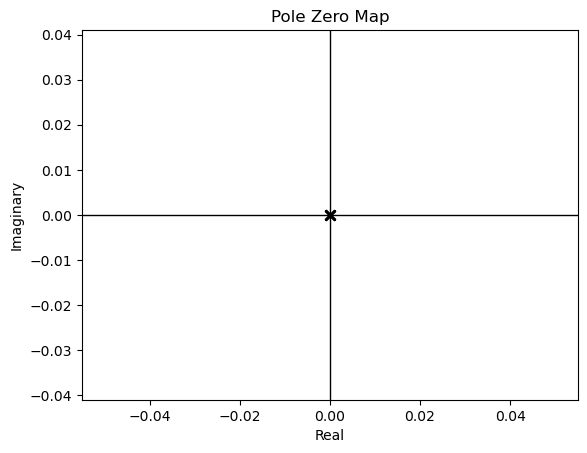

In [ ]:
ctl.pzmap(rocket)

In [ ]:
ctl.zeros(rocket)

array([], dtype=float64)

In [ ]:
state_cost = np.eye(12)


In [ ]:
state_cost = np.eye(12)
state_cost[0,0] = .003
state_cost[1,1] = .003
state_cost[2,2] = 0
state_cost[5,5] = .1

state_cost

array([[0.003, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   ],
       [0.   , 0.003, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 1.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.1  , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.   , 0.   , 0.   ,
        0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.   , 0.   ,
        0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.   ,
        0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        1.   , 0.   

In [ ]:
state_cost = np.eye(12)
state_cost[6,6] = .3
state_cost[7,7] = .3
state_cost[8,8] = .3
state_cost

array([[1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.3, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.3, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.3, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ]])

In [ ]:
state_cost[9,9] = 30
state_cost[10,10] = 30
state_cost[11,11] = 30

In [ ]:
control_cost = np.eye(4)
control_cost[2,2] = 100
control_cost[3,3] = 100


In [ ]:
state_cost

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 30.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.]])

In [ ]:
K, S, E = ctl.lqr(A, B, state_cost, control_cost)

In [ ]:
Acl = A - np.matmul(B,K)

In [ ]:
controlled_rocket = ctl.ss(Acl, B, np.eye(12), np.zeros(B.shape))

(array([-2.26316003e+03+0.j        , -5.56844293e+00+4.31838602j,
        -5.56844293e+00-4.31838602j, -1.86220138e+00+1.50687383j,
        -1.86220138e+00-1.50687383j, -1.84958347e+00+1.50460441j,
        -1.84958347e+00-1.50460441j, -9.63679062e-01+0.30282047j,
        -9.63679062e-01-0.30282047j, -9.63925258e-01+0.30297938j,
        -9.63925258e-01-0.30297938j, -1.00000012e+00+0.j        ]),
 array([], dtype=float64))

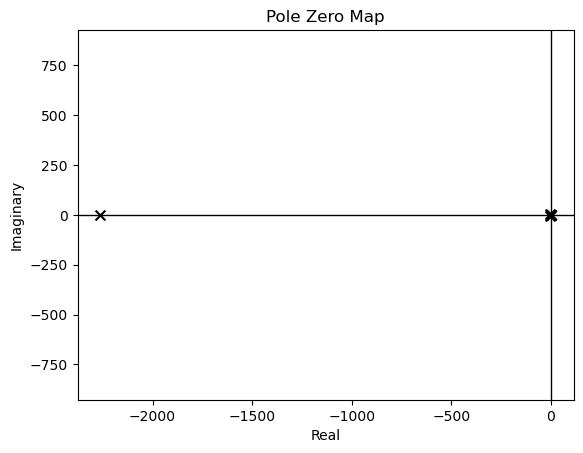

In [ ]:
ctl.pzmap(controlled_rocket)

In [ ]:
def controller(t, state):
  control = -np.matmul(K, state)
  return control[0]+9.81/2, control[1]+9.81/2, control[2], control[3]

In [ ]:

# Test case: Fall from 100m rocket with 10N thrust for first 2 seconds shooting 15 deg Y
y0 = np.array([0,0,0,  # x_dot body uvw
               5,5,5,  # X global
               0,0,0,  # theta_dot pqr
               0,0,0]) # theta

g_ = 9.81


t_span = (0.0, 15.0)
t_eval = np.arange(0,15,0.001)

params =  (g_, m_, CpCt_, motor_to_cm_, D_, controller)

result_solve_ivp = solve_ivp(rocket_full, t_span, y0, t_eval=t_eval,
                             events=[], args=params, method='LSODA')

resdf = pd.DataFrame(result_solve_ivp.y.T,columns=state_labels, index=result_solve_ivp.t)

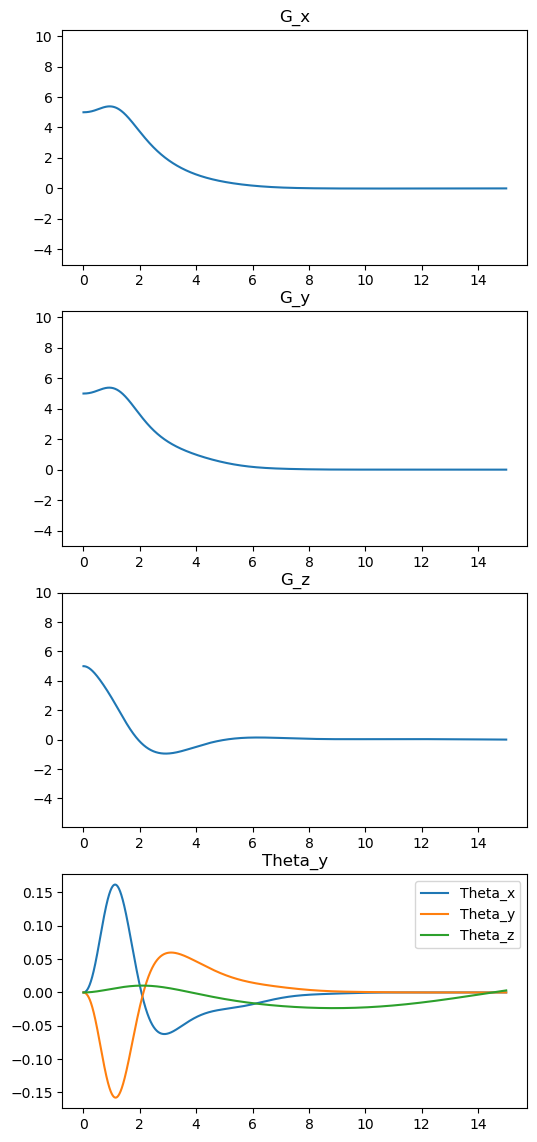

In [ ]:
fig, ax = plt.subplots(4,1, figsize=(6,14))
ax[0].plot(resdf.index,resdf['G_x'])
ax[0].set_title('G_x')
ax[0].set_ylim([min(-5, resdf['G_x'].min()-5), max(5, resdf['G_x'].max()+5)])
ax[1].plot(resdf.index,resdf['G_y'])
ax[1].set_title('G_y')
ax[1].set_ylim([min(-5, resdf['G_y'].min()-5), max(5, resdf['G_y'].max()+5)])
ax[2].plot(resdf.index,resdf['G_z'])
ax[2].set_title('G_z')
ax[2].set_ylim([min(-5, resdf['G_z'].min()-5), max(5, resdf['G_z'].max()+5)])
ax[3].plot(resdf.index,resdf['Theta_x'], label='Theta_x')
ax[3].plot(resdf.index,resdf['Theta_y'], label='Theta_y')
ax[3].plot(resdf.index,resdf['Theta_z'], label='Theta_z')
ax[3].set_title('Theta_y')
ax[3].legend()
plt.show()

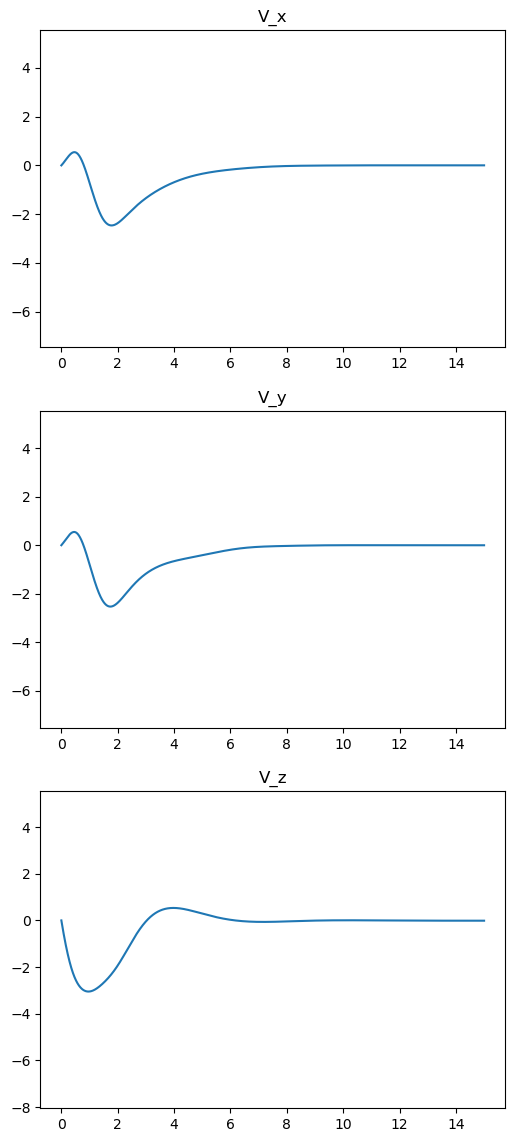

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(6,14))
ax[0].plot(resdf.index,resdf['V_x'])
ax[0].set_title('V_x')
ax[0].set_ylim([min(-5, resdf['V_x'].min()-5), max(5, resdf['V_x'].max()+5)])
ax[1].plot(resdf.index,resdf['V_y'])
ax[1].set_title('V_y')
ax[1].set_ylim([min(-5, resdf['V_y'].min()-5), max(5, resdf['V_y'].max()+5)])
ax[2].plot(resdf.index,resdf['V_z'])
ax[2].set_title('V_z')
ax[2].set_ylim([min(-5, resdf['V_z'].min()-5), max(5, resdf['V_z'].max()+5)])

plt.show()

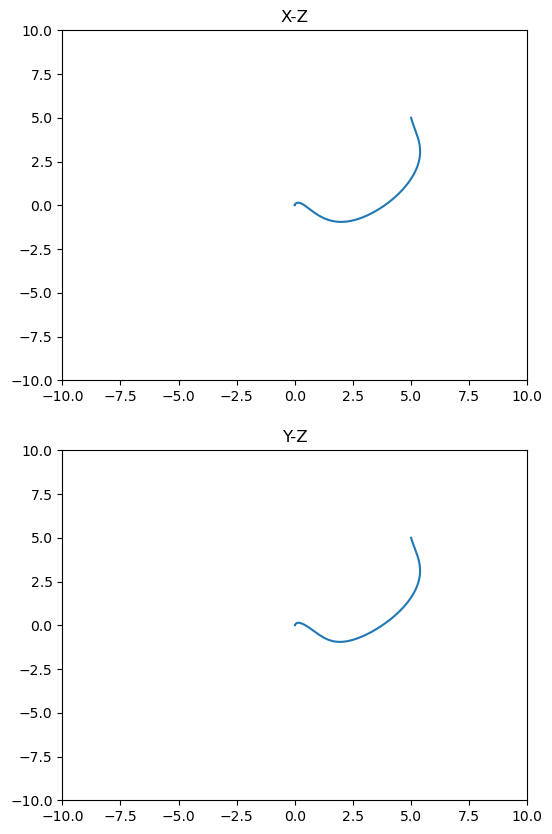

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(6,10))
ax[0].plot(resdf['G_x'],resdf['G_z'])
ax[0].set_title('X-Z')
ax[0].set_xlim([-10,10])
ax[0].set_ylim([-10,10])

ax[1].plot(resdf['G_y'],resdf['G_z'])
ax[1].set_title('Y-Z')
ax[1].set_xlim([-10,10])
ax[1].set_ylim([-10,10])

plt.show()

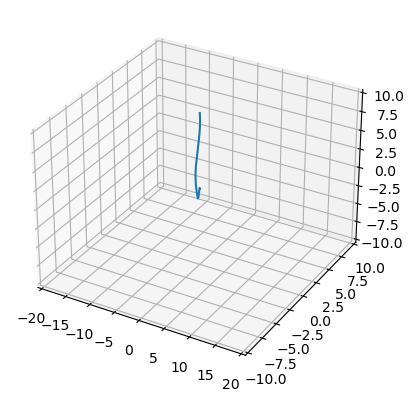

In [ ]:
ax = plt.figure().add_subplot(projection='3d')



ax.plot(resdf['G_x'], resdf['G_y'], resdf['G_z'])
ax.set_xlim([-20,20])
ax.set_ylim([-10,10])
ax.set_zlim([-10,10])

plt.show()

